Автоэнкодер с малоразмерным скрытым представлением для сжатия текстовых данных.

Датасет: https://huggingface.co/datasets/lksy/ru_instruct_gpt4/viewer

In [ ]:
!pip install wordcloud numpy pandas torch scikit-learn

EDA Анализ

In [27]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS


In [22]:
file_name = './ru_instruct_gpt4.jsonl'

# Создаём пустой датафрейм
df = pd.DataFrame(columns=['instruction'])
 
# Открываем файл и читаем его построчно
with open(file_name, 'r') as file:
    for line in file:
        # Конвертируем строку в словарь
        data = json.loads(line)
        # Извлекаем данные из колонки 'a' и добавляем их в датафрейм
        df = pd.concat([df, pd.DataFrame([data.get('instruction')], columns=['instruction'])], ignore_index=True)

# Выводим первые несколько строк датафрейма для проверки
print(df.head())


                                         instruction
0                      Расскажи сказку народов мира.
1  В каком из следующих предложений употреблено с...
2  Опиши важность семейных традиций и праздников ...
3  Назови главные отличия романтизма и реализма в...
4  Вспомни и напиши названия трех книг одного изв...


<Axes: >

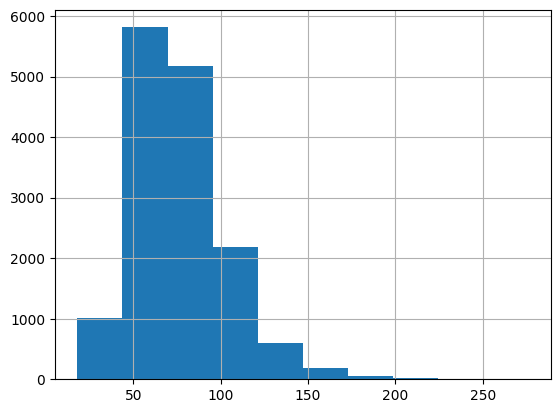

In [23]:
import pandas as pd

# Гистограмма показывает, что предложения варьируются от 25 до 225 символов.
df['instruction'].str.len().hist()

<Axes: >

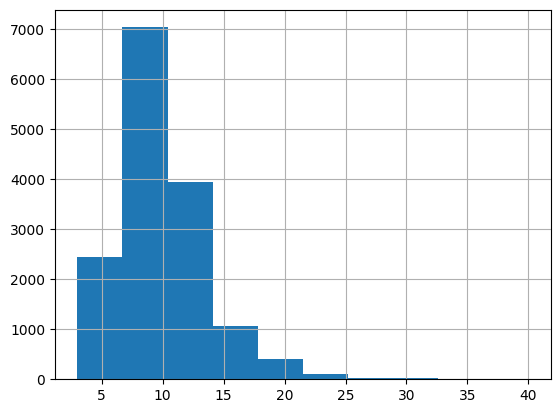

In [24]:
# Понятно, что количество слов находится в диапазоне от 3 до 35

df['instruction'].str.split().map(lambda x: len(x)).hist()

<Axes: >

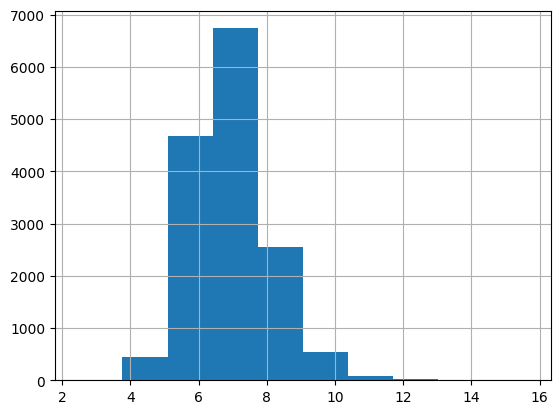

In [15]:
# Средняя длина слова варьирется от 4 до 13, при этом 7 является наиболее распространенной длиной.

df['instruction'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

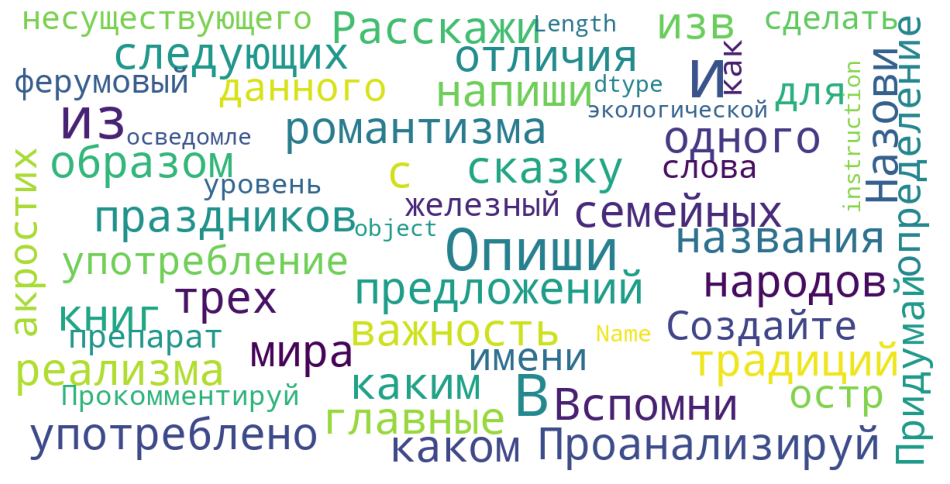

In [20]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud = wordcloud.generate(str(data))
 
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['instruction'])

Обучение автоэнкодера

In [29]:

import torch
import torch.nn as nn
from sklearn.feature_extraction.text import CountVectorizer

# Векторизация текста
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['instruction']).toarray()

# Конвертируем в тензоры PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)

# Определение автоэнкодер
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Кодировщик
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim)
        )
        # Декодировщик
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = X_tensor.shape[1]
encoding_dim = 2  # Малоразмерное скрытое представление

# Модель
model = Autoencoder(input_dim, encoding_dim)

# Функция потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    output = model(X_tensor)
    loss = criterion(output, X_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Тестирование модели
with torch.no_grad():
    encoded_texts = model.encoder(X_tensor)
    decoded_texts = model.decoder(encoded_texts)

print("Исходные векторы:", X_tensor.numpy())
print("Сжатые векторы:", encoded_texts.numpy())
print("Восстановленные векторы:", decoded_texts.numpy())


Epoch [1/10], Loss: 0.2574
Epoch [2/10], Loss: 0.2568
Epoch [3/10], Loss: 0.2563
Epoch [4/10], Loss: 0.2557
Epoch [5/10], Loss: 0.2552
Epoch [6/10], Loss: 0.2547
Epoch [7/10], Loss: 0.2541
Epoch [8/10], Loss: 0.2536
Epoch [9/10], Loss: 0.2531
Epoch [10/10], Loss: 0.2525
Исходные векторы: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Сжатые векторы: [[-0.27026662 -0.19538769]
 [-0.27026662 -0.19538769]
 [-0.27026662 -0.19538769]
 ...
 [-0.27026662 -0.19538769]
 [-0.27026662 -0.19538769]
 [-0.27026662 -0.19538769]]
Восстановленные векторы: [[0.37529173 0.5363201  0.32759047 ... 0.60272825 0.3370341  0.4971216 ]
 [0.37529173 0.5363201  0.32759047 ... 0.60272825 0.3370341  0.4971216 ]
 [0.37529173 0.5363201  0.32759047 ... 0.60272825 0.3370341  0.4971216 ]
 ...
 [0.37529173 0.5363201  0.32759047 ... 0.60272825 0.3370341  0.4971216 ]
 [0.37529173 0.5363201  0.32759047 ... 0.60272825